In [7]:
import sys
import os
import importlib
import pandas as pd
import numpy as np
import geopandas
import seaborn
sys.path.insert(0, os.path.join(os.environ["DESEABEL_PATH"], "ocean_ecosystem"))
import noise_impactor
import simulator
import marine_fauna
import marine_map
import matrix_conversion
importlib.reload(matrix_conversion)
importlib.reload(marine_map)
importlib.reload(marine_fauna)
importlib.reload(simulator)
importlib.reload(noise_impactor)

from noise_impactor import FishingBoat, PileDriving
from simulator import Simulator
from marine_fauna import Fish
from marine_map import MarineMap
from matrix_conversion import *

path_data = "s3://deseabel/marine_fauna/fish.geojson"

## Create 3 boats and one fish species

In [8]:
lat = 46.129384382974024
lon = -1.8588552648399457
boat1 = FishingBoat(id=1, lat=lat, lon=lon, speed=20, length=23)
#boat2 = FishingBoat(id=2, lat=45.84, lon=-1.71, speed=15, length=23)

path_data = "s3://deseabel/marine_fauna/fish.geojson"

fish = Fish(path_data)

## Initialize a marine map with specific shapes

In [9]:
# Example
width = 100000
height = 100000
step = 1000
longitude_west = -2.3595
latitude_north = 46.4181

marine_map = MarineMap(width, height, step, longitude_west, latitude_north)

## Initialize a Simulator

In [10]:
list_noise_impactor=[boat1]
simu = Simulator(marine_map, list_noise_impactor=list_noise_impactor, list_marine_fauna=[])

# Add manually other objects
simu.add_marine_fauna(fish)

#### Plot the heatmap of the noise from the map

<AxesSubplot: >

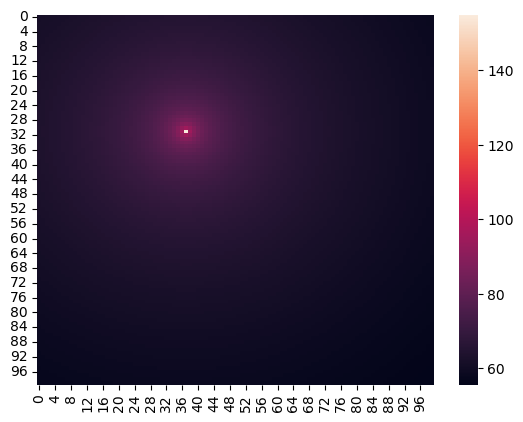

In [11]:
#marine_map.matrix_decibel_gpd.to_file(".data/matrix_decibel.geojson", driver="GeoJSON")
seaborn.heatmap(marine_map.matrix_decibel)

## Compute the marine fauna impact for the fish species

In [12]:
simu.update_marine_fauna_impact("fish")

#### Show different results
1. Plot the corresponding quantified matrix of the different levels of noise impacts
2. Print the corresponding array impact
3. Plot The corresponding location of the fish species

<AxesSubplot: >

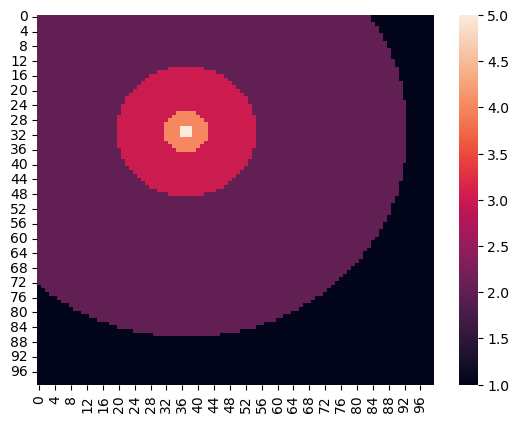

In [13]:
#marine_map.matrix_decibel_impact_quantified_gpd.to_file("../data/matrix_decibel_impact_quantified", driver="GeoJSON")
seaborn.heatmap(marine_map.matrix_decibel_impact_quantified)

In [ ]:
# with open(f"../data/array_impact_{fish._species}.json", "w") as f_out:
#     json.dump({i: impact for i, impact in enumerate(fish.array_impact)}, f_out)
fish.array_impact

In [ ]:
coords = marine_map.get_coords_xy_from_geopandas(fish.spot_gpd)
matrix_res = np.zeros(marine_map.matrix_decibel.shape)

matrix_res[coords[:, 0], coords[:, 1]] = 1

seaborn.heatmap(matrix_res)

## Use the API

In [2]:
import requests
import os
import time
zone = "la_rochelle"
path_data = "s3://deseabel/marine_fauna/fish.geojson"
species = "fish"

# urls
url_base = "http://0.0.0.0:8080/"
#url_base = "http://35.180.66.86/"
url_show = os.path.join(url_base, f"show/{zone}")
url_init = os.path.join(url_base, "initialize_user")
url_add_boat = os.path.join(url_base, f"add_boat/fishing_boat?zone={zone}")
url_add_marine_fauna = os.path.join(url_base, f"add_marine_fauna/fish?zone={zone}&geojson_path={path_data}")
url_update_impact = os.path.join(url_base, f"update_marine_fauna_impact?zone={zone}&species={species}")
url_decibel_matrix = os.path.join(url_base, f"decibel_matrix?zone={zone}")
url_decibel_matrix_impact_quantified = os.path.join(url_base, f"decibel_matrix_impact_quantified?zone={zone}")
url_percentage_marine_fauna_impact_by_level = os.path.join(url_base, f"percentage_marine_fauna_impact_by_level?zone={zone}&species={species}")

requests.get(url_base).text

'{"message":"Welcome to the DeSEAbel API !!!"}'

In [3]:
token1 = requests.get(url_init).json()["token"]
time.sleep(1)
token2 = requests.get(url_init).json()["token"]
header1 = {"token": token1}
header2 = {"token": token2}

In [4]:
lat = 46.129384382974024
lon = -1.8588552648399457
boat1 = {"id": 1, "lat": lat, "lon": lon, "speed": 20, "length": 23}
#boat2 = {"id": 2, "lat": 44.85, "lon": -4.9, "speed": 25, "length": 23}
#boat3 = {"id": 3, "lat": 44.5, "lon": -5.2, "speed": 27, "length": 15}
res = requests.post(url_add_boat, json=boat1, headers=header1)
#res = requests.post(url_add_boat, json=boat2, headers=header1)
#res = requests.post(url_add_boat, json=boat3, headers=header1)
# id_to_del = 2
# url_delete_boat = os.path.join(url_base, f"remove_noise_impactor?id={id_to_del}")
# requests.get(url_delete_boat).text

res.json()

{'message': 'The boat with id=1 has been added in the environment.'}

In [5]:
requests.get(url_show, headers=header1).text

'{"noise_impactors":"[<noise_impactor.FishingBoat object at 0x7f704683a1c0>]","marine_faunas":"[<marine_fauna.Fish object at 0x7f70673b0760>]"}'

In [6]:
requests.get(url_show, headers=header2).text

'{"noise_impactors":"[]","marine_faunas":"[<marine_fauna.Fish object at 0x7f70673b0760>]"}'

In [7]:
requests.post(url_update_impact, headers=header1)

<Response [200]>

In [8]:
res = requests.get(url_decibel_matrix, headers=header1)

In [9]:
res = requests.get(url_decibel_matrix_impact_quantified, headers=header1)

In [15]:
res = requests.get(url_percentage_marine_fauna_impact_by_level, headers=header1)

In [16]:
res.text

'{"result":{"0":0.0,"1":0.16709732988802756,"2":0.7243755383290267,"3":0.09474590869939707,"4":0.012058570198105082,"5":0.0017226528854435831}}'

In [ ]:
requests.get("http://0.0.0.0:8080/users").text